In [74]:
import pandas as pd
import numpy as np


def load_dataframe(base_path, batch, plate, data_level):
    """
    Load a dataframe given the base path, batch name, plate name, and data level.
    """
    path = f"{base_path}/{batch}/{plate}/{plate}_{data_level}.csv.gz"
    return pd.read_csv(path)


def drop_columns(df, columns_to_drop):
    """
    Drop specified columns or columns matching patterns if they exist in the dataframe.
    """
    exact_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

    # Identify columns based on patterns
    pattern_columns_to_drop = []
    for pattern in columns_to_drop:
        matched_columns = [col for col in df.columns if col.startswith(pattern)]
        pattern_columns_to_drop.extend(matched_columns)

    all_columns_to_drop = set(exact_columns_to_drop + pattern_columns_to_drop)
    return df.drop(columns=all_columns_to_drop, axis=1)

In [38]:
# Define paths using dictionary with context/repo names
base_paths = {
    "local_repo": "../1.run-workflows/profiles",
    "external_repo": "../2019_05_28_Neuronal_Cell_Painting/profiles",
}

# Update datasets to include 'key' for each entry
datasets = [
    {
        "key": "stem",
        "base_path": base_paths["local_repo"],
        "batch": "NCP_STEM_1",
        "plate": "BR_NCP_STEM_1",
        "data_level": "augmented",
    },
    {
        "key": "progen",
        "base_path": base_paths["local_repo"],
        "batch": "NCP_PROGENITORS_1",
        "plate": "BR00127194",
        "data_level": "augmented",
    },
    {
        "key": "neuron_p72",
        "base_path": base_paths["external_repo"],
        "batch": "2022_03_03_NCP_NEURONS_2_20x",
        "plate": "BR00132672",
        "data_level": "augmented",
    },
    {
        "key": "neuron_p73",
        "base_path": base_paths["external_repo"],
        "batch": "2022_03_03_NCP_NEURONS_2_20x",
        "plate": "BR00132673",
        "data_level": "augmented",
    },
    {
        "key": "astro_p1",
        "base_path": base_paths["external_repo"],
        "batch": "2022-08-07_batch",
        "plate": "Plate1_PE_PP96",
        "data_level": "augmented",
    },
    {
        "key": "astro_p2",
        "base_path": base_paths["external_repo"],
        "batch": "2022-08-07_batch",
        "plate": "PE_PP_Plate2",
        "data_level": "augmented",
    },
]

# Load and process dataframes using dictionary
dfs = {}

for dataset in datasets:
    dfs[dataset["key"]] = load_dataframe(
        dataset["base_path"], dataset["batch"], dataset["plate"], dataset["data_level"]
    )

In [39]:
def check_matching_columns(dfs_list):
    """
    Check if all dataframes in the list have the same columns.
    If not, report the columns that are different and raise an error.
    """
    reference_columns = set(dfs_list[0].columns)
    mismatch_info = []

    for idx, df in enumerate(
        dfs_list[1:], 2
    ):  # Start from 2 to account for 0-based indexing + reference df
        current_columns = set(df.columns)

        extra_columns = current_columns - reference_columns
        missing_columns = reference_columns - current_columns

        if extra_columns or missing_columns:
            info = f"DataFrame {idx} Mismatch:\n"
            if extra_columns:
                info += (
                    f"{len(extra_columns)} Extra Columns:\n\t"
                    + "\n\t".join(extra_columns)
                    + "\n"
                )
            if missing_columns:
                info += f"{len(missing_columns)} Missing Columns:\n\t" + "\n\t".join(
                    missing_columns
                )
            mismatch_info.append(info)

    if mismatch_info:
        detailed_error = "Dataframes have different columns:\n" + "\n".join(
            mismatch_info
        )
        # raise ValueError(detailed_error)
        # don't raise error for now just print
        print(detailed_error)

In [75]:
def process_dataframes_by_cell_type(dfs, cell_type_data):
    """
    Process dataframes for a specific cell type:
    - Drop specified columns
    - Rename specified columns
    - Add new columns with default values
    - Check if columns match (if multiple dataframes)
    - Concatenate dataframes for the cell type
    """
    cell_dfs = [dfs[key] for key in cell_type_data["keys"]]

    # Drop columns
    columns_to_drop = cell_type_data.get("columns_to_drop", [])
    cell_dfs = [drop_columns(df, columns_to_drop) for df in cell_dfs]

    # Rename columns
    columns_to_rename = cell_type_data.get("columns_to_rename", {})
    cell_dfs = [df.rename(columns=columns_to_rename) for df in cell_dfs]

    # Add new columns with default values
    columns_to_add = cell_type_data.get("columns_to_add", {})
    for col, default_val in columns_to_add.items():
        for df in cell_dfs:
            df[col] = default_val

    # Check columns if there are multiple dataframes for the cell type
    if len(cell_dfs) > 1:
        check_matching_columns(cell_dfs)

    # Concatenate dataframes for the cell type
    return pd.concat(cell_dfs)


# Define cell types and their associated keys and columns to drop
cell_types_data = {
    "stem": {
        "keys": ["stem"],
        "columns_to_drop": [
            "Cytoplasm_Parent_Cells",
            "Cytoplasm_Parent_Nuclei",
            "Image_",
            "Metadata_well_position",
            "Metadata_Assay_Plate_Barcode",
        ],
        "columns_to_add": {
            "Metadata_Object_Count": np.nan,
            "Metadata_Site_Count": np.nan,
            "Nuclei_ObjectSkeleton_NumberNonTrunkBranches_CellImageSkel": np.nan,
            "Nuclei_ObjectSkeleton_NumberBranchEnds_CellImageSkel": np.nan,
            "Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_CellImageSkel": np.nan,
        },
    },
    "progen": {
        "keys": ["progen"],
        "columns_to_drop": [
            "Cytoplasm_Parent_Cells",
            "Cytoplasm_Parent_Nuclei",
            "Image_",
            "Metadata_well_position",
            "Metadata_Assay_Plate_Barcode",
            "Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel",
        ],
    },
    "neuron": {
        "keys": ["neuron_p72", "neuron_p73"],
        "columns_to_drop": [
            "Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel",
            "Image_",
            "Metadata_well_position",
            "Metadata_Assay_Plate_Barcode",
            "Metadata_EXPERIMENT_NAME",
        ],
        "columns_to_rename": {
            "Metadata_LINE_ID": "Metadata_line_ID",
            "Metadata_DENSITY": "Metadata_plating_density",
            "Metadata_plate_map_name": "Metadata_Plate_Map_Name",
            "Metadata_GENOTYPE": "Metadata_line_condition",
        },
        "columns_to_add": {"Metadata_line_source": "unknown"},
    },
    "astro": {
        "keys": ["astro_p1", "astro_p2"],
        "columns_to_drop": [
            "Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel",
            "Image_",
            "Metadata_well_position",
            "Metadata_Assay_Plate_Barcode",
            "Metadata_METADATA_SOURCE",
            "Metadata_Count_Nuclei",
            "Metadata_Count_Cells",
            "Metadata_Count_Cytoplasm",
        ],
        "columns_to_rename": {
            "Metadata_METADATA_SAMPLE_ID": "Metadata_line_ID",
            "Metadata_METADATA_DENSITY": "Metadata_plating_density",
            "Metadata_plate_map_name": "Metadata_Plate_Map_Name",
            "Metadata_METADATA_CONDITION": "Metadata_line_condition",
        },
        "columns_to_add": {"Metadata_line_source": "unknown"},
    },
}

# Process dataframes for each cell type
processed_dfs = {
    cell_type: process_dataframes_by_cell_type(dfs, data)
    for cell_type, data in cell_types_data.items()
}


In [76]:
for cell_type, df in processed_dfs.items():
    print(f"{cell_type} shape: {df.shape}")

stem shape: (384, 4303)
progen shape: (384, 4303)
neuron shape: (768, 4303)
astro shape: (188, 4303)


In [77]:
check_matching_columns([processed_dfs["stem"], processed_dfs["progen"]])

In [70]:
check_matching_columns([processed_dfs["progen"], processed_dfs["neuron"]])

In [71]:
check_matching_columns([processed_dfs["progen"], processed_dfs["astro"]])

In [72]:
check_matching_columns([processed_dfs["neuron"], processed_dfs["astro"]])

In [84]:
for cell_type, df in processed_dfs.items():
    print(f"Summary for {cell_type}:\n")

    # Filter columns starting with "Metadata_"
    metadata_cols = [
        col
        for col in df.columns
        if col.startswith("Metadata_") and col != "Metadata_Well"
    ]

    for col in metadata_cols:
        unique_vals = df[col].unique()
        print(f"{col}: {len(unique_vals)} unique values")
        print(unique_vals)
        print("\n")

    print("=" * 40)


Summary for stem:

Metadata_Plate: 1 unique values
['BR_NCP_STEM_1']


Metadata_Plate_Map_Name: 1 unique values
['BR_NCP_STEM_1']


Metadata_plating_density: 1 unique values
[10000]


Metadata_line_ID: 48 unique values
[ 1 30  9 26  4 34 15 36  2 16 20 12 17 39 37 42  7 29 11 38 43 18  6 27
 41 32 46 33 14 23 22  3 28  5 35 13 19 24 21 31 10 45 44 47 40 48  8 25]


Metadata_line_condition: 2 unique values
['control' 'deletion']


Metadata_line_source: 3 unique values
['human' 'isogenic_deletion' 'isogenic_control']


Metadata_Object_Count: 1 unique values
[nan]


Metadata_Site_Count: 1 unique values
[nan]


Summary for progen:

Metadata_Plate: 1 unique values
['BR00127194']


Metadata_Site_Count: 9 unique values
[9 7 6 8 4 5 2 1 3]


Metadata_Object_Count: 362 unique values
[ 2486  3014   838    68  3012  3427  1968  2265  1544  2010  3293  5538
  1726  1858  3042  5869   703  1110   415  2236  2603  4419   867  2571
  3769  2946    10    90  3684  3102  2630  2912  2819  2145  6570  5

In [86]:
check_matching_columns(
    [
        processed_dfs["stem"],
        processed_dfs["progen"],
        processed_dfs["neuron"],
        processed_dfs["astro"],
    ]
)

# Concatenate all dataframes
all_df = pd.concat(processed_dfs.values())

all_df = (
    pd.concat(
        processed_dfs.values(), keys=processed_dfs.keys(), names=["Metadata_cell_type"]
    ).reset_index(level="Metadata_cell_type")
    # .drop(columns="level_1")
)


In [87]:
# remove all colunmsn not starting with Metadata_
all_df = all_df.loc[:, all_df.columns.str.startswith("Metadata_")]


In [88]:
# Extract 'Metadata_line_ID' and related columns from 'stem' dataframe
# because it has the most complete information
lookup_df = processed_dfs["stem"][
    ["Metadata_line_ID", "Metadata_line_condition", "Metadata_line_source"]
]

# Drop duplicates to have a unique mapping for each 'Metadata_line_ID'
lookup_df = lookup_df.drop_duplicates().set_index("Metadata_line_ID")

# Map 'Metadata_line_condition' and 'Metadata_line_source' using the lookup table
all_df["Metadata_line_condition"] = all_df["Metadata_line_ID"].map(
    lookup_df["Metadata_line_condition"]
)
all_df["Metadata_line_source"] = all_df["Metadata_line_ID"].map(
    lookup_df["Metadata_line_source"]
)


In [108]:
# Group by desired columns, count the frequency of each combination, and sort the result

columns = [
    "Metadata_line_ID",
    "Metadata_line_condition",
    "Metadata_line_source",
]

sorted_df = (
    all_df.groupby(columns)
    .size()
    .reset_index(name="Replicates")
    .sort_values(by=columns)
)

print(sorted_df)


    Metadata_line_ID Metadata_line_condition Metadata_line_source  Replicates
0                  1                 control                human          36
1                  2                 control                human          36
2                  3                 control                human          36
3                  4                 control                human          36
4                  5                 control                human          36
5                  6                 control                human          36
6                  7                 control                human          36
7                  8                 control                human          33
8                  9                 control                human          36
9                 10                 control                human          36
10                11                 control                human          36
11                12                 control                huma

In [109]:
columns = [
    "Metadata_line_ID",
    "Metadata_cell_type",
    "Metadata_line_condition",
    "Metadata_line_source",
]

sorted_df = (
    all_df.groupby(columns)
    .size()
    .reset_index(name="Replicates")
    .sort_values(by=columns)
)

print(sorted_df)

     Metadata_line_ID Metadata_cell_type Metadata_line_condition  \
0                   1              astro                 control   
1                   1             neuron                 control   
2                   1             progen                 control   
3                   1               stem                 control   
4                   2              astro                 control   
..                ...                ...                     ...   
187                47               stem                deletion   
188                48              astro                deletion   
189                48             neuron                deletion   
190                48             progen                deletion   
191                48               stem                deletion   

    Metadata_line_source  Replicates  
0                  human           4  
1                  human          16  
2                  human           8  
3                  human   

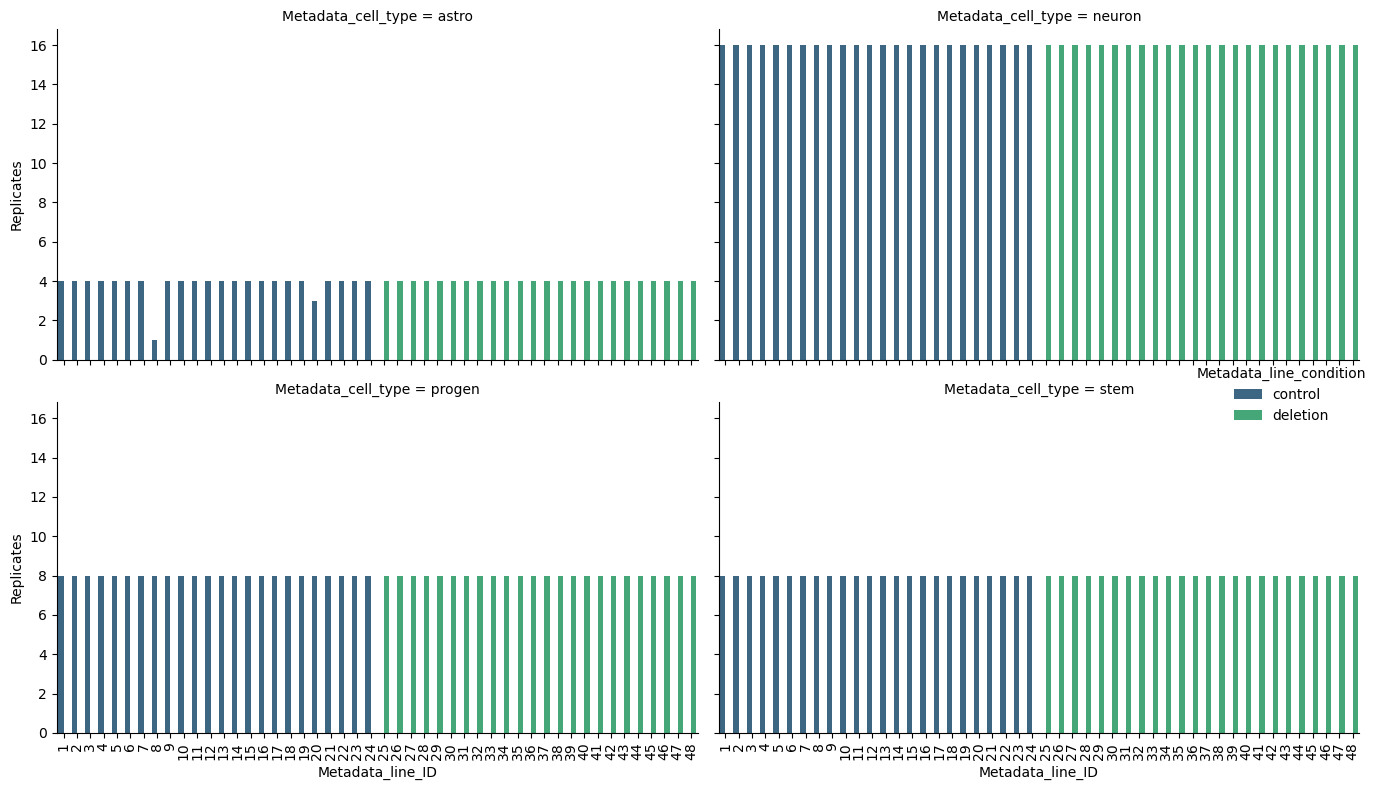

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a faceted bar plot
g = sns.catplot(
    data=sorted_df,
    x="Metadata_line_ID",
    y="Replicates",
    hue="Metadata_line_condition",
    col="Metadata_cell_type",
    col_wrap=2,
    kind="bar",
    height=4,
    aspect=1.5,
    palette="viridis",
)

g.set_xticklabels(rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [112]:
desired_order = [
    "Metadata_Plate",
    "Metadata_Well",
    "Metadata_Plate_Map_Name",
    "Metadata_line_ID",
    "Metadata_line_condition",
    "Metadata_line_source",
    "Metadata_plating_density",
    "Metadata_Object_Count",
    "Metadata_Site_Count",
]

# Get the remaining columns using set difference
remaining_columns = list(set(all_df.columns) - set(desired_order))

# Combine to form the new column order
new_column_order = desired_order + remaining_columns

# Reorder the DataFrame columns
all_df = all_df[new_column_order]


In [ ]:
# Save the DataFrame to a Parquet file

all_df.to_parquet("output/ncp_augmented.parquet", index=False)
